# <font size="10"><p style="text-align: center;color:#2a4b8d">A short guide on where to safely eat delicious food in Chicago</font>

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27
import seaborn as sns
import os, sys
import re
from datetime import datetime, date, time
import json
import folium

**Requirements**

The project repo contains a notebook with data collection and descriptive analysis, properly commented, and the notebook ends with a more structured and informed plan for what comes next (all the way to a plan for the presentation). These sections of the notebook should be filled in by milestone 3.

We will evaluate this milestone according to how well these previous steps (or other reasonable ones) have been done and documented, the quality of the code and its documentation, the feasibility and critical awareness of the project.

# <p style="color:#2e86c1">Data collection

## Chicago Food Inspections (CFI) dataset

This is our main [dataset](https://www.kaggle.com/chicago/chicago-food-inspections), where the information is derived from inspections of restaurants and other food establishments in Chicago from January 1, 2010 to the present. Inspections are performed by staff from the Chicago Department of Public Health’s Food Protection Program using a standardized procedure. This dataset contains 22 columns and as of October 23, 2019 there are 194’784 entries (updated frequently, so subject to change). 

In [2]:
cfi = pd.read_csv('data/chicago-food-inspections/food-inspections.csv')
print('There are {0} samples and {1} columns in the dataset'.format(cfi.shape[0],cfi.shape[1]))

The dataset has size:  (194784, 22)


## Yelp Reviews (YR) dataset

Yelp.com is a website that helps people find great local businesses such as restaurants based on customer reviews. Each business has a page where visitors can write comments and add a general grade reflecting their experience there. The [Yelp fusion API](https://www.yelp.com/developers/documentation/v3/business_search) enables us to access relevant information on restaurants such as their rating and their respective number of reviews. When trying to scrap the data, we first encountered an issue of how to uniquely identify each restaurant. Indeed, the Yelp API enables us to pass as an argument the latitude and longitude of all places we want to query. We initially thought that this will enable us to find the right businesses. However, the Yelp coordinates do not match exactly the ones of our dataset. Thus, quering by latitude/longitude didn't give us the right business (we generally obtained restaurants, which were closed to the one in which we were interested).

Therefore, we had to come up with another way to query our dataset. By looking at the API documentation on Yelp Fusion website, we found another function, called `business_match_query`, which enables us to give as argument the name and complete address of every restaurant. Trying this function on a few cases showed us that by doing this "cross-research", taking into account several pieces of information on the businesses, enables us to obtain the right results. However, one disadvantage of this function is that the `business_match_query` doesn't enable us to access directly the Yelp reviews. But it gives us the Yelp ID, which is a unique identifier on Yelp website for a business. As a next step, we can use the `requests` package to access the reviews by giving it as an argument the Yelp ID.

This way, we were able to obtain the right results. One disadvantage of this method is the fact that we need to query the dataset twice. First to obtain the Yelp ID via the `business_match_query` function, and secondly to obtain the reviews using the ID. For this reason, we haven't queried our whole dataset yet. We have now queried approximately 17'500 businesses of a total of over 20'000. So we should be able to have the full dataset ready before Wednesday (as Yelp restricts us to 5'000 queries per day).

For the code of the scrapping, please refer to the file called `API_yelp`. In this file, we simply implemented the procedure explained above. Every day, we scrapped 2'500 rows of our dataset, then saved it as a csv file, and re-open this file the next day to continue the scrapping and so on (of course, we made some copies of it during the procedure to make sure to not lose any information).

## Crimes dataset

This [dataset](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2) reflects reported incidents of crime that occurred in the City of Chicago from 2001 to present, and is updated daily with a seven-day lag. For our project, we will however only focus on the data from January 1, 2010 onwards to match with the CFI dataset. Data is extracted from the Chicago Police Department's CLEAR system and due to privacy concerns, addresses are only shown at the block level. This level of resolution is however more than sufficient for the analyses we aim to undertake. This dataset contains 30 columns and as of October 23, 2019 there are 6'992’400 entries (updated frequently, so subject to change).

In [25]:
crimes = pd.read_csv('data/crimes.csv', low_memory=False)
print('There are {0} samples and {1} columns in the dataset'.format(crimes.shape[0],crimes.shape[1]))

There are 6992400 samples and 30 columns in the dataset


---

# <p style="color:#2e86c1"> Data preprocessing

- That you understand what’s into the data (formats, distributions, missing values, correlations, etc.).
- That you considered ways to enrich, filter, transform the data according to your needs.

## Chicago Food Inspections (CFI) dataset

Note that the last 5 columns only contain NaN values, and will therefore be removed from the dataset. The set is in a simple csv file, which makes it easy to read using Pandas. By quickly inspecting the dataset on Pandas, we can note that there are 121 duplicates, which is only a tiny fraction of the data compared to the number of rows, ensuring we will have enough data to work with. In this dataset, we have information on the location of the restaurants, where 7 columns contain spatial indicators, excluding the columns on the community area and zip codes, which are full of NaN values and will hence be disregarded. Information on the inspections consist of 5 columns including the inspection type, date, id, results and possible violations. The remaining columns are related to the restaurant itself, including the facility type, licence number, DBA, AKA names and risk.

### 1. Exploring columns

In [4]:
# Drop columns that only contain NaNs
cfi.drop(columns = ['Historical Wards 2003-2015', 'Zip Codes', 'Community Areas', 'Census Tracts', 'Wards'], inplace = True)

# Remove inspection for which buisnesses were closed or not found
cfi = cfi[(cfi['Results'] != 'Out of Business') & (cfi['Results'] != 'Business Not Located')]

# Remove buisnesses without any license number
cfi = cfi[(cfi['License #'] != 0)]

### 2. Facility inspection

We only want to select inspections on facilities that prepare the food themselves. That is, we want to exclude grocery stores, gas stations, schools, etc. 

In [5]:
# Initializing the regex 
REST = "rest|diner|sushi|taqueria|hot.dog|grill|cuisine|jap.nese|sandwich|bbq|pizza|burrito|mcdo|mc do|kimchee|chicken|pollo|fish|pasta|taco|rice|fast.food|bagel|noodle|sub|pita|kebab|kabob|seafood|shrimp|thai|african|chinese|burger|porkchop|wendy"
BAR = "bar|hooka|bistro|brewery"
TAVERN = "tavern"
COFFEE = "cafe|caffe|coffee"
DESSERT = "gelato|ice.cream|paleteria|dessert|cand.|chocolate|cookies|cake|patisserie|sweet"
BAKERY = "bakery|donut"
DRINKS = "shake|juice|smoothie|tea"
SNACK = "snack|snak|popcorn"
DELI = "deli"
regexes = [REST, BAR, TAVERN, COFFEE, DESSERT, BAKERY, DRINKS, SNACK, DELI]
types = ['Restaurant', 'Bar', 'Tavern', 'Coffee', 'Dessert', 'Bakery', 'Drinks', 'Snaks', 'Deli']

# Get rows with no facility type
no_facility = cfi['Facility Type'].isnull() 

# Change the facility type according to the regexes
for i, regex in enumerate(regexes):
    facility = cfi['Facility Type'].str.contains(pat = regex, case=False, regex=True, na=False)
    dba = cfi['DBA Name'].str.contains(pat = regex, case = False, regex = True, na=False)
    cfi.loc[facility|(no_facility & dba), 'Facility Type'] = types[i]
    
# Drop rows with no and not of interest facility type
cfi.dropna(axis = 0, subset = ['Facility Type'], inplace = True)
index_names = cfi[~cfi['Facility Type'].isin(types)].index
cfi.drop(index_names, inplace = True)

### 3. Locations inspection

There are no rows that don't have one of either latitude, longitude and address. The address, however, is insufficient, and thus all samples without latitude & longitude will be removed.

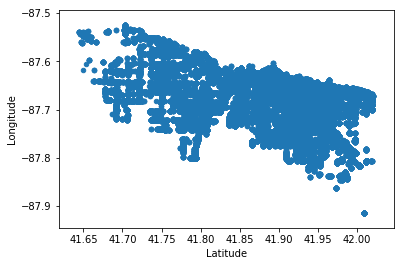

In [6]:
# Drop location with missing latitude or longitude
no_location = cfi[cfi['Latitude'].isnull() | cfi['Longitude'].isnull()].index
cfi.drop(no_location, inplace = True)

# Plot the locations
cfi.plot.scatter(x = 'Latitude', y ='Longitude')
plt.show()

This scatter plot shows that all of the data does seem to really be in Chicago.

### 4. Group places

In [7]:
import datetime

# Drop unused columns
cfi.drop(columns = ['AKA Name', 'Location'], inplace = True)

# Convert Inspection date in date format
cfi['Inspection Date'] = cfi['Inspection Date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%f'))

# Generate groups according to license number
groups = cfi.groupby(['License #'])

# Aggregates other columns either in a list format or by taking the mode
columns = (list(cfi.columns))
columns.remove('License #')
columns_to_list = ['Inspection ID', 'Inspection Date', 'Inspection Type', 'Results', 'Violations']

for i, col in enumerate(columns):
    if(col not in columns_to_list): # Take the mode value
        df = groups[col].agg(pd.Series.mode).reset_index(name=col)
    else: # Aggregate the resluts in a list
        df = groups[col].apply(list).reset_index(name=col)
        
    if(i==0):
        cfi_groups = df
    else:
        cfi_groups = cfi_groups.merge(df, on = ['License #'])

### 5. New data sets

Restaurants must be visited at least every 3 years so we generate a new dataset with places that have been inspected at least once in the last three years. We assume that if this is not the case the place has shut down.

In [8]:
# Generate the new dataset with places that have been inspected at least once in the last three years 
print(cfi_groups.shape)
cfi_groups['DBA Name'] = cfi_groups['DBA Name'].apply(lambda x: str(x).lower())
cfi_groups.loc[:, 'Last Inspection Year'] = cfi_groups['Inspection Date'].map(lambda x: x[0].year)
cfi_recent = cfi_groups[cfi_groups['Last Inspection Year'] > 2015].reset_index()
print(cfi_recent.shape)

(20386, 15)
(12891, 17)


Now let's make a dataset grouping the food chains. According to Wikipedia, the top 15 biggest food chains of the US are: Subway, McDonald's, Starbucks, KFC, Burger King, Pizza Hut, Domino's, Dunkin', Baskin-Robbins, Hunt Brothers Pizza, Taco Bell, Wendy's, Hardee's, Orange Julius and Papa John's Pizza.

In [9]:
from difflib import get_close_matches

top_15_chains = ['subway', 'mcDonald\'s', 'starbucks', 'kfc', 'burger king', 'pizza hut', 'domino\'s',\
                 'dunkin\'', 'baskin-robbins', 'hunt brothers pizza', 'taco bell', 'wendy\'s',\
                 'hardee\'s', 'orange julius', 'papa john\'s pizza']

names = cfi_recent['DBA Name']

cfi_recent['Chain'] = np.nan
for i, name in enumerate(names):
    match = get_close_matches(name,top_15_chains,n=1,cutoff=0.7) # CUTOFF VALUE TO BE TUNED
    if(match):
        cfi_recent.loc[i,'Chain'] = match

In [10]:
cfi_recent[cfi_recent['Chain']=='papa john\'s pizza']['DBA Name'].value_counts()

papa john's pizza                10
armand's pizza                    2
papa johns pizza                  2
papa john's pizza & yogenfruz     1
papa romeo's pizza                1
papanino's pizza                  1
pat's pizza                       1
chapo's pizza                     1
papa romeo pizza                  1
papa john's hyde park             1
papa joe's pizza                  1
john's pizzeria                   1
Name: DBA Name, dtype: int64

## Crimes dataset

### 1. Exploring columns

In [26]:
print(crimes.dtypes)

ID                              int64
Case Number                    object
Date                           object
Block                          object
IUCR                           object
Primary Type                   object
Description                    object
Location Description           object
Arrest                           bool
Domestic                         bool
Beat                            int64
District                      float64
Ward                          float64
Community Area                float64
FBI Code                       object
X Coordinate                  float64
Y Coordinate                  float64
Year                            int64
Updated On                     object
Latitude                      float64
Longitude                     float64
Location                       object
Historical Wards 2003-2015    float64
Zip Codes                     float64
Community Areas               float64
Census Tracts                 float64
Wards       

The dataset is also available directly on [Chicago's data portal](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2), where it comes with a nice explanation of the columns that helps understand the meaning of all 30 features.

> **ID** - Unique identifier for the record. <br>
**Case Number** - The Chicago Police Department RD Number (Records Division Number), which is unique to the incident.<br>
**Date** - Date when the incident occurred. this is sometimes a best estimate.<br>
**Block** - The partially redacted address where the incident occurred, placing it on the same block as the actual address.<br>
**IUCR** - The Illinois Unifrom Crime Reporting code. This is directly linked to the Primary Type and Description. See the list of IUCR codes at https://data.cityofchicago.org/d/c7ck-438e.<br>
**Primary Type** - The primary description of the IUCR code.<br>
**Description** - The secondary description of the IUCR code, a subcategory of the primary description.<br>
**Location Description** - Description of the location where the incident occurred.<br>
**Arrest** - Indicates whether an arrest was made.<br>
**Domestic** - Indicates whether the incident was domestic-related as defined by the Illinois Domestic Violence Act.<br>
**Beat** - Indicates the beat where the incident occurred. A beat is the smallest police geographic area – each beat has a dedicated police beat car. Three to five beats make up a police sector, and three sectors make up a police district. The Chicago Police Department has 22 police districts. See the beats at https://data.cityofchicago.org/d/aerh-rz74.<br>
**District** - Indicates the police district where the incident occurred. See the districts at https://data.cityofchicago.org/d/fthy-xz3r.<br>
**Ward** - The ward (City Council district) where the incident occurred. See the wards at https://data.cityofchicago.org/d/sp34-6z76.<br>
**Community Area** - Indicates the community area where the incident occurred. Chicago has 77 community areas. See the community areas at https://data.cityofchicago.org/d/cauq-8yn6.<br>
**FBI Code** - Indicates the crime classification as outlined in the FBI's National Incident-Based Reporting System (NIBRS). See the Chicago Police Department listing of these classifications at http://gis.chicagopolice.org/clearmap_crime_sums/crime_types.html.<br>
**X Coordinate** - The x coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. This location is shifted from the actual location for partial redaction but falls on the same block.<br>
**Y Coordinate** - The y coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. This location is shifted from the actual location for partial redaction but falls on the same block.<br>
**Year** - Year the incident occurred.<br>
**Updated On** - Date and time the record was last updated.<br>
**Latitude** - The latitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block.<br>
**Longitude** - The longitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block.<br>
**Location** - The location where the incident occurred in a format that allows for creation of maps and other geographic operations on this data portal. This location is shifted from the actual location for partial redaction but falls on the same block.<br>

In addition, we can see based on their website's information that in fact only 22 columns instead of 30 contain valuable information. The remaining 8 columns in fact pertain to an older classification system that we don't need to take into account. Therefore, we drop these columns for our analysis.

In [27]:
# drop old columns
cols = ['Historical Wards 2003-2015','Zip Codes', 'Community Areas', 'Census Tracts', 
        'Wards', 'Boundaries - ZIP Codes','Police Districts', 'Police Beats']
crimes.drop(cols, axis=1, inplace=True)

In [28]:
with pd.option_context('display.max_columns', None): display(crimes.head())

ID Case Number                    Date                 Block  IUCR  \
0  11034701    JA366925  01/01/2001 11:00:00 AM       016XX E 86TH PL  1153   
1  11227287    JB147188  10/08/2017 03:00:00 AM    092XX S RACINE AVE  0281   
2  11227583    JB147595  03/28/2017 02:00:00 PM       026XX W 79TH ST  0620   
3  11227293    JB147230  09/09/2017 08:17:00 PM  060XX S EBERHART AVE  0810   
4  11227634    JB147599  08/26/2017 10:00:00 AM   001XX W RANDOLPH ST  0281   

          Primary Type                          Description  \
0   DECEPTIVE PRACTICE  FINANCIAL IDENTITY THEFT OVER $ 300   
1  CRIM SEXUAL ASSAULT                       NON-AGGRAVATED   
2             BURGLARY                       UNLAWFUL ENTRY   
3                THEFT                            OVER $500   
4  CRIM SEXUAL ASSAULT                       NON-AGGRAVATED   

  Location Description  Arrest  Domestic  Beat  District  Ward  \
0            RESIDENCE   False     False   412       4.0   8.0   
1            RESIDENCE   False     False  2222      22.0  21.0   
2                OTHER   False     False   835       8.0  18.0   
3            RESIDENCE   False     False   313       3.0  20.0   
4          HOTEL/MOTEL   False     False   122       1.0  42.0   

   Community Area FBI Code  X Coordinate  Y Coordinate  Year  \
0            45.0       11           NaN           NaN  2001   
1            73.0       02           NaN           NaN  2017   
2            70.0       05           NaN           NaN  2017   
3            42.0       06           NaN           NaN  2017   
4            32.0       02           NaN           NaN  2017   

               Updated On  Latitude  Longitude Location  
0  08/05/2017 03:50:08 PM       NaN        NaN      NaN  
1  02/11/2018 03:57:41 PM       NaN        NaN      NaN  
2  02/11/2018 03:57:41 PM       NaN        NaN      NaN  
3  02/11/2018 03:57:41 PM       NaN        NaN      NaN  
4  02/11/2018 03:57:41 PM       NaN        NaN      NaN

### 2. Cleaning entries

As we have seen in the data collection part, the whole dataset includes almost 7M entries and 30 columns. However, only roughly 3M entries pertain to our study period (2010 until present) to match with the CFI dataset.

In [29]:
# Only use data from January 1st, 2010 onwards
crimes = crimes[crimes['Year'] > 2009]

Let's also have a look at any missing values for each feature:

In [30]:
crimes.isnull().sum()

ID                          0
Case Number                 2
Date                        0
Block                       0
IUCR                        0
Primary Type                0
Description                 0
Location Description     5595
Arrest                      0
Domestic                    0
Beat                        0
District                    1
Ward                       59
Community Area            401
FBI Code                    0
X Coordinate            21028
Y Coordinate            21028
Year                        0
Updated On                  0
Latitude                21028
Longitude               21028
Location                21028
dtype: int64

Based on these results, we decide to drop all entries with a nan value in any feature except location description, as this will anyways not be part of our analysis.

In [31]:
nan_entries = crimes[['Case Number', 'District', 'Ward', 'Community Area', 'Latitude', 'Longitude']]\
                    .isnull().sum(axis=1)
print('There are {0} entries with at least one missing value in our targeted features'.format((nan_entries>0).sum()))
crimes = crimes[nan_entries<1]
print('After cleaning, there are {0} remaining samples'.format(crimes.shape[0]))

There are 21473 entries with at least one missing value in our targeted features
After cleaning, there are 2894407 remaining samples


### 3. Cleaning columns

Let's now turn our attention to the features in our dataset. 

In [32]:
crimes.columns

Index(['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type',
       'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat',
       'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate',
       'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude',
       'Location'],
      dtype='object')

Some columns will not be relevant for our analysis and we hence drop them. The X and Y coordinate are not necessary given that we work with the longitude/latitude data and location is simply an aggregate of the longitude and latitude. Also, we are not really interested in the location description and the update dates of the log entries for the purposes of our analysis.

In [33]:
# drop unnecessary columns
cols = ['Location Description', 'X Coordinate', 'Y Coordinate', 'Updated On', 'Location']
crimes.drop(cols, axis=1, inplace=True)

Also, we make sure that the data type of our features matches with its meaning and that it allows easy usage.

In [34]:
# convert floats to integers
crimes[['District', 'Ward', 'Community Area']] = crimes[['District', 'Ward', 'Community Area']].astype(int)

# convert booleans to integers (in python, True = 1 and False = 0)
crimes[['Arrest', 'Domestic']] = crimes[['Arrest', 'Domestic']].astype(int)

# structure the date and time for better usability
crimes['Date'] = crimes['Date'].apply(lambda d: datetime.strptime(d, '%m/%d/%Y %H:%M:%S %p'))

### 4. Detecting outliers

#### 4.1 Geographical data

Let's check the crimes distribution by location:

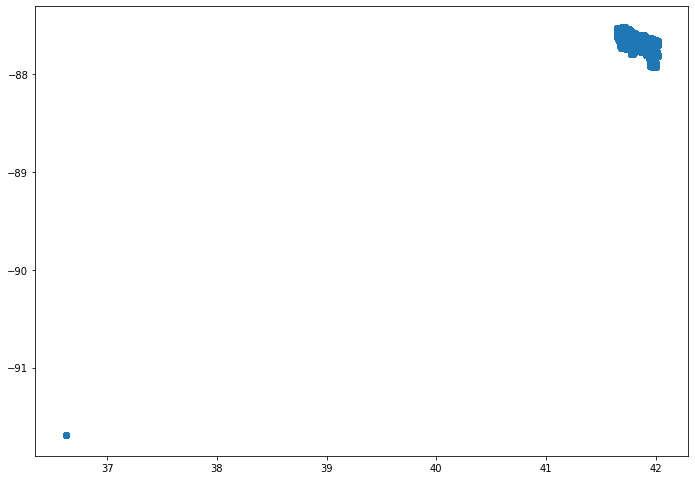

In [35]:
plt.scatter(crimes['Latitude'], crimes['Longitude'])

We realize that there must be some entries that do not correspond to the city of Chicago, whose latitude/longitude is 41.8781° N, 87.6298° W. Therefore, we are going to exclude datapoints below 40° latitude and -90° longitude:

In [36]:
in_chigaco = (crimes['Longitude'] > -90) & (crimes['Latitude'] > 40)
print('There are {0} entries with a location outside of Chicago'.format(crimes.shape[0]-in_chigaco.sum()))
crimes = crimes[in_chigaco]

There are 76 entries with a location outside of Chicago


Let's recheck whether the geographical distribution now makes sense:

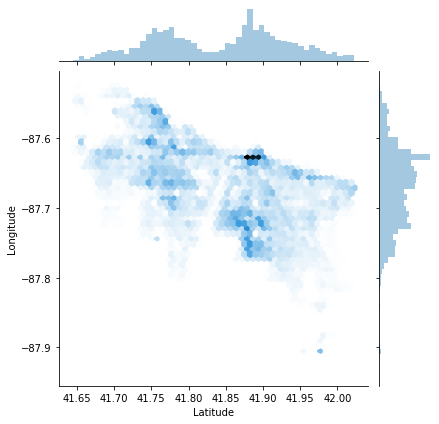

In [37]:
sns.jointplot(x=crimes['Latitude'], y=crimes['Longitude'], kind='hex')

#### 4.2 Community area data

It is known that Chicago has 77 community areas, numbered from 1 to 77. Let's therefore discard any values different from this range.

In [38]:
areas = np.arange(1,78)
in_areas = crimes['Community Area'].isin(areas)
print('There are {0} entries with a wrong area code'.format(crimes.shape[0]-in_areas.sum()))
crimes = crimes[in_areas]

There are 9 entries with a wrong area code


Also, Chicago has 25 police districts, numbered 1 to 25. 

In [39]:
districts = np.arange(1,26)
in_districts = crimes['District'].isin(districts)
print('There are {0} entries with a wrong district code'.format(crimes.shape[0]-in_districts.sum()))
crimes = crimes[in_districts]

There are 57 entries with a wrong district code


## Yelp Reviews (YR) dataset

The data scraped from Yelp has been directly added on the clean version of our primary CFI dataset by just adding 4 columns: the Yelp name of the business, the number of reviews, the rating and the array containing all the grades. We added the Yelp name just to see if the business obtained was the one that we were looking for. Having the full array of reviews is very interesting, as it will help us to a more in-depth analysis on the distribution, and not only looking at the mean. Note that the number of reviews and the rating could both be simply obtained from the array of reviews (the rating is just the mean of the array, while the number of reviews is just the length of the array). For the format of these columns, the rating and number of reviews are float numbers, the reviews is an array of float and the Yelp name is just a string.

Of course, we weren't able to obtain information on every restaurant (for instance, some of them might not have a Yelp page, other restaurants might have shutdown in the meantime and thus they don't have a Yelp page anymore, and finally in some cases, we might just have issues with the quering). On average, we were able to obtain information on 75% of our dataset, which is a nice proportion taking into account all of the issues mentionned above. Note that by default the business for which we didn't have any Yelp information have the Yelp columns filled with NaN values.

!!!put some information regarding the fact that the data should be clean

---

# <p style="color:#2e86c1">Descriptive analysis 

>Our research questions defined in the README give us a good framework for our descriptive analysis. Up to the second milestone, we aimed to:
>- evolution of the food inspection results
>- food chains / food categories (type of cuisine, facility type etc.)
>- a possible correlation of hygienic standards of the food places and their respective customer reviews
>- patterns of neighborhood crime rates

## Evolution of food inspection results

camille

How did the food safety in Chicago evolve geographically since the year 2010? Does the same area/restaurants remain safe over time?

## Analysis of food chains and categories

hugues

Are large food chains or specific cuisine types more prone to fail food inspections?

## Correlation analysis  of hygienic standards of the food places and customer reviews

(jeremie)

Are there correlates between the food inspection fail rate of areas and online Yelp ratings of restaurants?

## Patterns of neighborhood crime rates

Chicago has 77 different community areas and our crimes dataset contains information about the community area where the incident occurred. Therefore, let's see whether there are some distinct patterns among these areas.

In [40]:
# get the total number of incidents per community area
cts = crimes['Community Area'].value_counts()
areas = pd.DataFrame(cts.values, cts.index, columns=["crimes"])
areas['code'] = areas.index
# convert the code into the string to allow for matching with geojson data later on
areas['code'] = areas['code'].apply(str)
areas.head()

crimes code
25  182705   25
8   107130    8
43   96816   43
23   91839   23
29   91613   29

We can now have a look at the data in a bar plot and see that there are huge differences among the different areas.

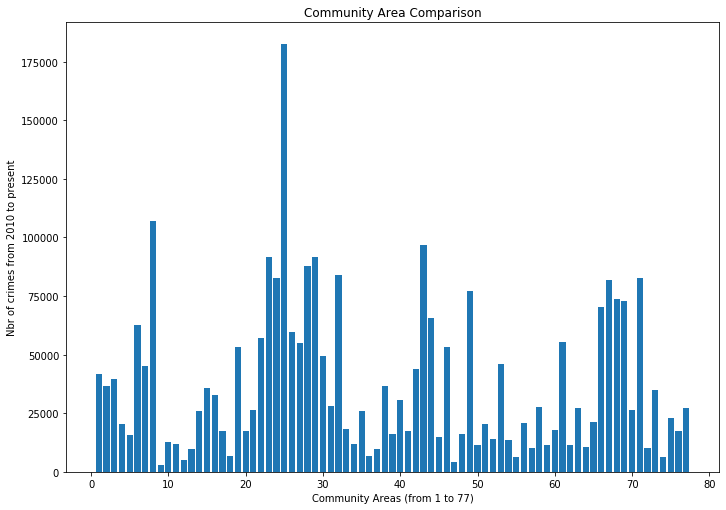

In [41]:
plt.bar(cts.index, cts.values)
plt.xlabel('Community Areas (from 1 to 77)')
plt.ylabel('Nbr of crimes from 2010 to present')
plt.title('Community Area Comparison')
plt.show()

Let's turn to folium and first just have a look at the different community area boundaries using [Chicago's Data Portal](https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Community-Areas-current-/cauq-8yn6) geojson data in the map visible [here](https://github.com/huguesvinzant/ada-2019-project-jech/data/area_boundaries.html).

In [43]:
chicago_coord = [41.8781, -87.6298]
# define map
m = folium.Map(location=chicago_coord, tiles='cartodbpositron')
# get the data of the boundaries from the geojson file
area_geo_path = r'data/boundaries.geojson'
geo_json_data = json.load(open(area_geo_path))
# add the boundaries to the map
folium.GeoJson(geo_json_data).add_to(m)
# save the plot in html for rendering purposes
m.save(outfile= "data/area_boundaries.html")

m

As a next step, we want to add the information regarding the total number of crimes per community area since 2010 in the map:

In [49]:
# define the map
m = folium.Map(location=[41.8781, -87.6298], tiles='cartodbpositron')

# coloring is using data from a pandas dataframe bound to geojson data through the area code
folium.Choropleth(
    geo_data=geo_json_data,
    name='choropleth',
    data=areas,
    columns=['code', 'crimes'],
    key_on='feature.properties.area_num_1',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Total number of crimes from 2010 to present'
).add_to(m)
folium.LayerControl().add_to(m)
m.save(outfile= "data/area_counts.html")

m

In the map visible [here](https://github.com/huguesvinzant/ada-2019-project-jech/data/area_counts.html), we can now see that the different areas have a very different number of crimes as suggested by the barplot.

However, the incidence rate per population size would be even more informative to know which areas are problematic. To do so, we use the census data by community area from 2017 found [here](http://www.actforchildren.org/wp-content/uploads/2018/01/Census-Data-by-Chicago-Community-Area-2017.pdf) as a proxy for the population from 2010 to the present in each area.

In [45]:
census = pd.read_csv('data/census.csv', sep=';')
census.head()

code  count
0     1  53470
1     2  75185
2     3  54001
3     4  46881
4     5  35406

In [46]:
# convert the area code to int for the merge 
areas['code'] = areas['code'].astype(int)
areas = pd.merge(areas, census, how='inner', on='code')
# calculate the proportional incidence rate 
areas['prop'] = areas['crimes']/areas['count']
# reconvert the area code to string for binding with geojson data
areas['code'] = areas['code'].apply(str)
areas.head()

crimes code  count      prop
0  182705   25  97604  1.871901
1  107130    8  96466  1.110547
2   96816   43  42198  2.294327
3   91839   23  44841  2.048103
4   91613   29  36529  2.507953

In [48]:
# define the map
m = folium.Map(location=[41.8781, -87.6298], tiles='cartodbpositron')

# coloring is using data from a pandas dataframe bound to geojson data through the area code
folium.Choropleth(
    geo_data=geo_json_data,
    name='choropleth',
    data=areas,
    columns=['code', 'prop'],
    key_on='feature.properties.area_num_1',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Number of crimes from 2010 to present per inhabitant'
).add_to(m)
folium.LayerControl().add_to(m)
m.save(outfile= "data/area_crimerate.html")

m

In the map visible [here](https://github.com/huguesvinzant/ada-2019-project-jech/data/area_crimerate.html), we can observe that the results have actually changed quite drastically compared to the absolute number of crimes. There are now more areas with a relatively elevated incidence score.

---

>**We will finalize our descriptive analysis until milestone 3 by also doing:**
>- Correlation analysis: Are there correlates between the food inspection fail rate of areas and online Yelp ratings of restaurants?
>- Concluding analysis:
    - Where can one safely eat delicious food in Chicago?
    - Do certain neighborhoods offer a better overall dining experience based on customer reviews, and food as well as neighborhood safety?


## <span style='color:Gray'> Correlation analysis of hygienic standards and public safety

<span style='color:Gray'> Are there correlates between the food inspection fail rate of areas and public safety, measured through crime rates?

## <span style='color:Gray'> Concluding analysis

<span style='color:Gray'>
    
- Where can one safely eat delicious food in Chicago?
    
- Do certain neighborhoods offer a better overall dining experience based on customer reviews, and food as well as neighborhood safety?


---

# <p style="color:#2e86c1"> Project pipeline

- That you have updated your plan in a reasonable way, reflecting your improved knowledge after data acquaintance. In particular, discuss how your data suits your project needs and discuss the methods you’re going to use, giving their essential mathematical details in the notebook.
- That your plan for analysis and communication is now reasonable and sound, potentially discussing alternatives to your choices that you considered but dropped.

## Mid-term review

## Internal milestones

**Due by Friday, Nov 29**



**Due by Friday, Dec 06**



**Due by Friday, Dec 13**



**Due by Friday, Dec 20 - Project deadline**
- to hand in: data story in a platform of your choice (e.g., a blog post, or directly in GitHub), plus the final notebook (continuation of milestone 2).


**Due by Monday, Jan 20 - Poster presentation**



# update readme!!!